# Running Your First Models

In this notebook, we demonstrate the basic use of UCLCHEM's python module by running a simple model and then using the analysis functions to examine the output.

In [1]:
import uclchem

## A Simple Cloud

UCLCHEM's `cloud()` model is a spherical cloud of isothermal gas. We can keep a constant density or have it increase over time following a freefall equation. This model is generally useful whenever you want to model a homogeneous cloud of gas under constant conditions. For example, in the inner parts of a molecular cloud where Av $\gtrsim$ 10 there are very few depth dependent processes. You may wish to model the whole of this UV shielded portion of the cloud with a single `cloud()` model.

Due to the large number of parameters in a chemical model and the way fortran and python interaction, we find it is easiest to do parameter input through python dictionaries. In this block, we define param_dict which contains the parameters we wish to modify for this run. Every `uclchem.model` function accepts a dictionary as an optional argument. Every parameter has a default value which is overriden if that parameter is specified in this dictionary. You can find a complete list of modifiable parameters and their default values in [our parameter docs](/docs/parameters).


In [2]:
# set a parameter dictionary for phase 1 collapse model

out_species = ["SO","CO"]
param_dict = {
    "endAtFinalDensity": False,#stop at finalTime
    "freefall": False,#don't increase density in freefall
    "initialDens": 1e4, #starting density
    "initialTemp": 10.0,#temperature of gas
    "finalTime": 1.0e6, #final time
    "rout":0.1, #radius of cloud in pc
    "baseAv":1.0, #visual extinction at cloud edge.
    "outputFile": "../examples/test-output/static-full.dat",#full UCLCHEM output
    "abundSaveFile": "../examples/test-output/startstatic.dat",#save final abundances to file
}
result = uclchem.model.cloud(param_dict=param_dict,out_species=out_species)
print(result)


[1, 3.331065659699488e-11, 3.576305642378658e-05]


## Checking the output

At the end of the previous cell, we printed `result` which is a list returned by every UCLCHEM model function. The first element is always an integer which will be positive if the code completed and negative otherwise. You can send negative values to `uclchem.utils.check_error()` to get a more detailed error message.

The subsequent elements are the final abundances of any species listed in `out_species`, in this case we have the abundance of SO and CO. This is useful when we want to use UCLCHEM as part of something like an MCMC procedure, obtaining abundances for given parameters. However, we also write the final abundances of all species to `abundSaveFile` and the abundances of all species at every time step in `outputFile` so it is not necessary to acquire abundances in this way.

The output file is just a simple csv with some header rows, UCLCHEM has a utility function to read that file into a pandas dataframe. Let's load it up and look at it.



In [3]:
result_df=uclchem.analysis.read_output_file("../examples/test-output/static-full.dat")
result_df.head()

,Time,Density,gasTemp,av,zeta,point,H,#H,H+,@H,...,HS2+,HSO2+,H2S2+,H2S2,#H2S2,@H2S2,E-,BULK,SURFACE,radfield
0,0.000000e+00,10000.0,10.0,2.9287,1.0,1,0.5,1.000000e-30,1.000000e-30,1.000000e-30,...,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,0.000182,1.000000e-30,1.000000e-30,1.0
1,1.000000e-07,10000.0,10.0,2.9287,1.0,1,0.5,5.680300e-13,1.789040e-17,4.269620e-20,...,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,0.000182,5.629010e-20,7.488850e-13,1.0
2,1.000000e-06,10000.0,10.0,2.9287,1.0,1,0.5,5.646510e-12,1.789080e-16,4.219000e-18,...,1.631720e-30,1.000000e-30,1.000000e-30,1.000020e-30,1.000000e-30,1.000000e-30,0.000182,5.562330e-18,7.444370e-12,1.0
3,1.000000e-05,10000.0,10.0,2.9287,1.0,1,0.5,5.641430e-11,1.789520e-15,4.212520e-16,...,7.762720e-29,1.000000e-30,1.000000e-30,1.000050e-30,1.000000e-30,1.000010e-30,0.000182,5.554260e-16,7.438940e-11,1.0
4,1.000000e-04,10000.0,10.0,2.9287,1.0,1,0.5,5.480630e-10,1.793810e-14,4.079690e-14,...,7.864380e-27,1.000000e-30,1.000000e-30,1.000070e-30,1.000000e-30,1.000150e-30,0.000182,5.425070e-14,7.351600e-10,1.0


We can also test whether the model run went well by checking for element conservation. We do this because integrator errors often show up as a failure to conserve elemental abundances. 

We can use `check_element_conservation()` to test whether we conserve elements in this run. This function returns a dictionary where each entry gives the change in the total abundance of an element as a percentage of the original abundance. In an ideal case, these values are 0\% indicating the total abundance at the end of the model is exactly the same as the total at the start.

Changes of less than 1\% are fine for many cases but if they are too high, you could consider changing the `reltol` and `abstol` parameters that control the integrator accuracy. They are error tolerance so smaller values lead to smaller errors and (usually) longer integration times. The default values were chosen by running a large grid of models and choosing the tolerances with the lowest average run time from those that conserved elements well and rarely failed. Despite this, there are no one-size-fits-all perfect tolerances and you may run into issues with different networks or models.

In [4]:
conservation=uclchem.analysis.check_element_conservation(result_df,element_list=["H","N","C","O","S"])
print("Percentage change in total abundances:")
print(conservation)

Percentage change in total abundances:
{'H': '0.001%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%', 'S': '0.000%'}


## Plotting Results
Finally, you will want to plot your results. This can be done with any plotting library but UCLCHEM does provide a few functions to make quick plots. Note the use of $ symbols in the species list below, this gets the total ice abundance of a species. For two phase models, this is just the surface abudance but for three phase it is the sum of surface and bulk.

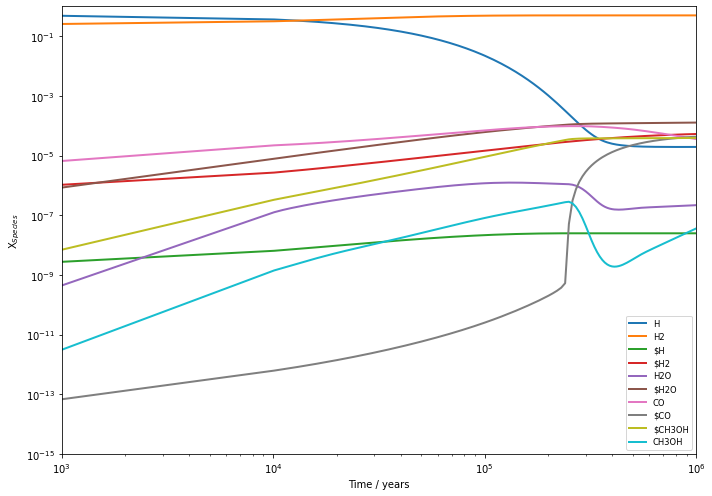

In [5]:
species=["H","H2","$H","$H2","H2O","$H2O","CO","$CO","$CH3OH","CH3OH"]
fig,ax=uclchem.analysis.create_abundance_plot(result_df,species,figsize=(10,7))
ax=ax.set(xscale="log",ylim=(1e-15,1),xlim=(1e3,1e6))

and that's it! You've run your first UCLCHEM model, checked that the element conservation is correct, and plotted the abundances.